In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler
%matplotlib inline

In [239]:
df = pd.read_csv('train.csv')
df

,p_id,no_times_pregnant,glucose_concentration,blood_pressure,skin_fold_thickness,serum_insulin,bmi,diabetes pedigree,age,diabetes
0,316,2,112,68,22,94,34.1,0.315,26,0
1,25,11,143,94,33,146,36.6,0.254,51,1
2,710,2,93,64,32,160,38.0,0.674,23,1
3,658,1,120,80,48,200,38.9,1.162,41,0
4,542,3,128,72,25,190,32.4,0.549,27,1
...,...,...,...,...,...,...,...,...,...,...
609,14,1,189,60,23,846,30.1,0.398,59,1
610,555,1,84,64,23,115,36.9,0.471,28,0
611,730,2,92,52,0,0,30.1,0.141,22,0
612,103,0,125,96,0,0,22.5,0.262,21,0


In [240]:
df.drop('p_id', axis=1, inplace=True)
for col in df.columns:
    print(col, len(df[col].unique()))

no_times_pregnant 17
glucose_concentration 127
blood_pressure 44
skin_fold_thickness 50
serum_insulin 163
bmi 237
diabetes pedigree 439
age 52
diabetes 2


In [214]:
# sns.pairplot(df, hue='diabetes')
# plt.show()
df.diabetes.value_counts()

0    400
1    214
Name: diabetes, dtype: int64

In [215]:
X = df.drop('diabetes', axis=1).values
y = df['diabetes'].values

In [216]:
mm = MinMaxScaler()
X = mm.fit_transform(X)

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [218]:
# X_train, y_train = SMOTE(n_jobs=-1, sampling_strategy=1.0).fit_resample(X_train, y_train)

In [219]:
#Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

In [220]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [221]:
class ANN_Model(nn.Module):
    def __init__(self, layer_sizes=[8,2], act_fn=[F.sigmoid]):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)])
        self.act_fn = act_fn
        
    def forward(self, x):
        for i, linear in enumerate(self.linears):
            x = self.act_fn[i](linear(x))
        return x

In [229]:
torch.manual_seed(42)
model = ANN_Model([8,300,300,2], [torch.tanh,torch.tanh,torch.sigmoid])

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 100
train_loss = []
test_loss = []
for i in range(1, epochs+1):
    y_pred = model.forward(X_train)
    loss1 = loss_func(y_pred, y_train)
    train_loss.append(loss1)
    loss2 = loss_func(model(X_test),y_test)
    test_loss.append(loss2)
    optimizer.zero_grad()
    loss2.backward()
    optimizer.step()
    if i%10 == 0:
        print(f"Epoch: {i}, train_loss: {loss1}, test_loss: {loss2}")

Epoch: 10, train_loss: 0.6085948944091797, test_loss: 0.6016061902046204
Epoch: 20, train_loss: 0.5541410446166992, test_loss: 0.5161080956459045
Epoch: 30, train_loss: 0.5540940761566162, test_loss: 0.4914872646331787
Epoch: 40, train_loss: 0.5411632657051086, test_loss: 0.4823282063007355
Epoch: 50, train_loss: 0.5473545789718628, test_loss: 0.47842609882354736
Epoch: 60, train_loss: 0.5477580428123474, test_loss: 0.47558116912841797
Epoch: 70, train_loss: 0.5438487529754639, test_loss: 0.4741886854171753
Epoch: 80, train_loss: 0.5479755401611328, test_loss: 0.47173938155174255
Epoch: 90, train_loss: 0.5497429966926575, test_loss: 0.47566089034080505
Epoch: 100, train_loss: 0.5505339503288269, test_loss: 0.47196170687675476


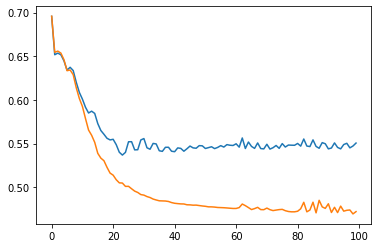

In [230]:
plt.plot(range(epochs), train_loss)
plt.plot(range(epochs), test_loss)
plt.show()

In [231]:
y_pred = []
for row in X_test:
    y_pred.append(model(row).argmax().item())
cm = confusion_matrix(y_pred, y_test)
print(cm)
print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

[[73 11]
 [ 7 32]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        84
           1       0.74      0.82      0.78        39

    accuracy                           0.85       123
   macro avg       0.83      0.84      0.84       123
weighted avg       0.86      0.85      0.86       123

0.8536585365853658


Text(33.0, 0.5, 'Predicted')

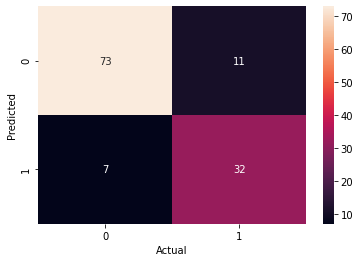

In [232]:
sns.heatmap(cm, annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [233]:
torch.save(model, 'ann.pt')

/Users/macbookpro/anaconda3/envs/sem5/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ANN_Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/macbookpro/anaconda3/envs/sem5/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/macbookpro/anaconda3/envs/sem5/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [234]:
test = pd.read_csv('test.csv')
predictions = pd.DataFrame()
predictions['p_id'] = test.p_id
test.drop('p_id', axis=1, inplace=True)
test = mm.transform(test)
with torch.no_grad():
    predictions['diabetes'] = [model(row.float()).argmax().item() for row in torch.from_numpy(test)]
predictions.to_csv('predict.csv', index=False)

In [235]:
predictions.diabetes.value_counts()

0    93
1    61
Name: diabetes, dtype: int64

In [236]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

SVC(kernel='linear')

In [109]:
y_pred = svc.predict(X_test)
cm = confusion_matrix(y_pred, y_test)
print(cm)
print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

[[61 21]
 [19 22]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        82
           1       0.51      0.54      0.52        41

    accuracy                           0.67       123
   macro avg       0.64      0.64      0.64       123
weighted avg       0.68      0.67      0.68       123

0.6747967479674797


Text(33.0, 0.5, 'Predicted')

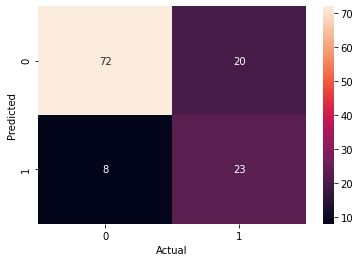

In [637]:
sns.heatmap(cm, annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [638]:
test = pd.read_csv('test.csv')
predictions = pd.DataFrame()
predictions['p_id'] = test.p_id
test.drop('p_id', axis=1, inplace=True)
test = mm.transform(test)
predictions['diabetes'] = svc.predict(test)
predictions.to_csv('predict.csv', index=False)

In [639]:
predictions.diabetes.value_counts()

0    109
1     45
Name: diabetes, dtype: int64